# 🏡 House Prices Prediction Project

### In this project, I predict house sale prices based on various features provided by the Ames Housing Dataset from Kaggle. The challenge lies in handling messy, real-world data, engineering powerful features, and building a robust model that generalizes well. This dataset sparked my interest because real estate pricing blends economics, human behavior, and a sprinkle of mystery — just like building empires. I wanted to sharpen my skills across the full data science pipeline, not just model training.

## Dataset Overview 📚

#### Type: Regression task

#### Target: SalePrice (the house price)

#### Features: 80+ attributes like lot size, year built, quality ratings, garage size, etc.

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
!pip install xgboost

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Ignore warnings for cleaner output
# import warnings
# warnings.filterwarnings('ignore')

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [4]:
df = pd.read_csv('house_prices_train.csv')  

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Fill numeric NaNs with median
num = df.select_dtypes(include=['float64', 'int64']).columns
for col in num:
    df[col].fillna(df[col].median(), inplace=True)

C:\Users\amira\AppData\Local\Temp\ipykernel_22548\185406700.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [ ]:
# Fill categorical NaNs with 'None' or mode
cat = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\amira\AppData\Local\Temp\ipykernel_22548\1132506290.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [7]:
# Drop columns with too many missing values 

df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [8]:
# Feature Engineering

df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = df['YrSold'] - df['YearBuilt']

In [9]:
# Find skewed numeric features
skewed_feats = df[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})

In [10]:
# Apply log(1+x) transform to features with skewness > 0.75

skewed_features = skewness[abs(skewness) > 0.75].dropna().index
for feat in skewed_features:
    df[feat] = np.log1p(df[feat])

In [11]:
# Encode Categorical Variables

df = pd.get_dummies(df)

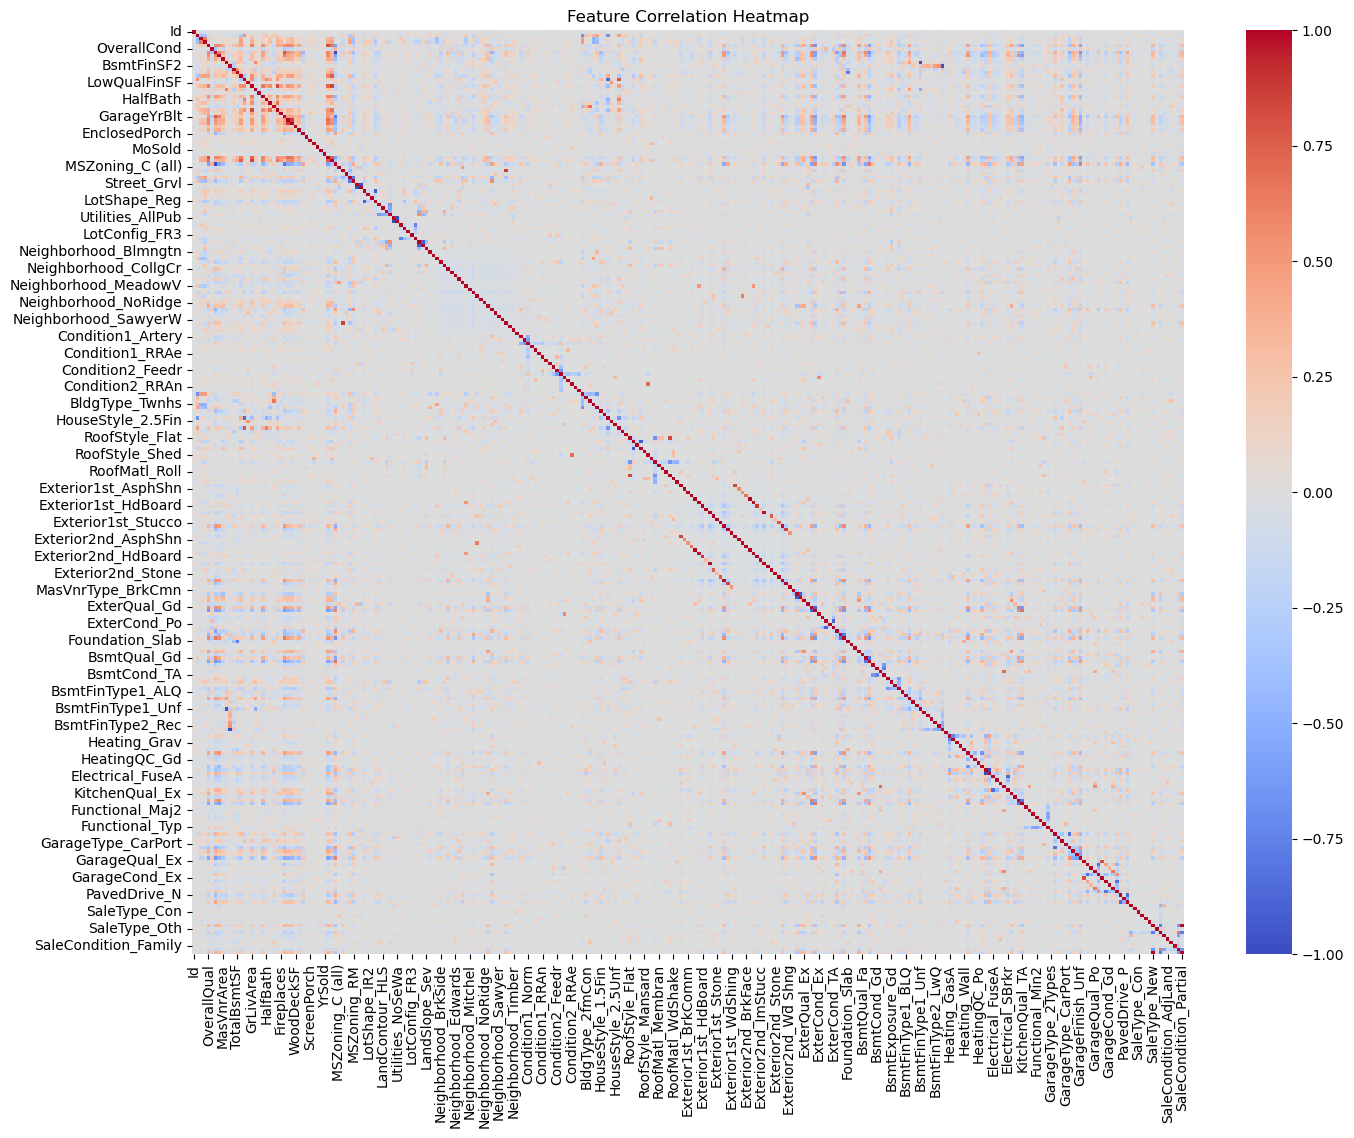

In [12]:
# Heatmap to see correlations

plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

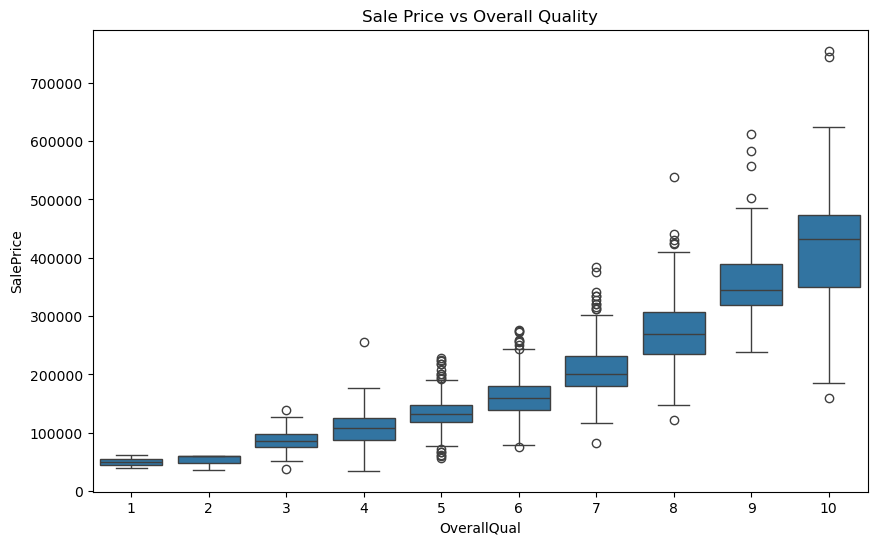

In [14]:
# Boxplot example
plt.figure(figsize=(10,6))
sns.boxplot(x="OverallQual", y="SalePrice", data=pd.read_csv('house_prices_train.csv'))  # Raw data to see real prices
plt.title('Sale Price vs Overall Quality')
plt.show()

In [15]:
# Train/Test Split

X = df.drop(['SalePrice', 'Id'], axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Modeling

# Baseline - Random Forest

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))

Random Forest RMSE: 0.146136623019255


In [19]:
# XGBoost Model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))

XGBoost RMSE: 0.1448835081241347


In [20]:
# Hyperparameter Tuning (XGBoost)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(XGBRegressor(random_state=42), param_distributions=param_grid,
                                   n_iter=10, scoring='neg_root_mean_squared_error', cv=5, random_state=42)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

final_preds = best_model.predict(X_test)

print("Tuned XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, final_preds)))

Tuned XGBoost RMSE: 0.1277186046556146


In [21]:
#  Cross-Validation Score

cv_score = cross_val_score(best_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print("CV Score:", cv_score.mean())



CV Score: -0.12503527022703448
